Modeling Temperature based off greenhouse gases


We have scraping code to get all the data, but not included in here as there was parsing afterwards to make sure the data was correct.  May include at end of notebook to show how the data was taken.

The WorldController class is used to parse weather data.

In [13]:
from datetime import datetime
import pandas as pd
import glob
import numpy as np
from StateObj import StateObj, findState
from matplotlib import pyplot
from DataModifier import DateMod
#change this class to contioulsy run in future.

##MAIN##

## CREATE/PARSE DATA FOR ML MODEL##


##CREATE OBJECTS FOR EACH CITY##
## City obj will handle data passed in through none statements
#CountryObj() # only do UNITED STATES
class WorldController:
    def __init__(self, oo = False):
        if oo:
            cityCountryDict = {}
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt', infer_datetime_format=True)
                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States' ]

                weatherGroup = weatherCityData.groupby(['Longitude', 'Latitude'])

                for  key, item in weatherGroup:
                    for city in item.City.unique():
                        cityCountryDict[city]   =  {'Location': [*item.Longitude.unique(), *item.Latitude.unique()]}
                # remove break

            allWeatherCityData = pd.DataFrame()
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt')

                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States']
                weatherCityData.index = pd.to_datetime(weatherCityData.index)
                weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
                weatherCityData = weatherCityData[weatherCityData.index.year < 2012]
                allWeatherCityData = allWeatherCityData.append(weatherCityData)
                for key in cityCountryDict.keys():
                    #pd.DataFrame(weatherCityData['AverageTemperature'].resample('W').sum(), columns=['AverageTemperature'])
                    weatherDict = weatherCityData[weatherCityData['City'] == key]['AverageTemperature']
                    i = 0
                    cityCountryDict[key]['time'] = []
                    for date in weatherDict.index.to_pydatetime():
                        otherDict = {date.strftime("%Y-%m-%d"): weatherDict.values[i]}
                        cityCountryDict[key]['time'].append(otherDict)
                        i+=1
                # remove break

            #cityCountryDict has City as key, Location : [longitude, latitude], time: [{WEEK TIMESTAMP : weather}...*]. Each child will find data to fit with its parent classes to pass data to it.  (read the csv, etc.)
            allStateData = pd.read_csv('./data/weather/GlobalLandTemperaturesByState.csv')
            allStateData = allStateData[allStateData['Country'] =='United States']
            allStateData.dt = pd.to_datetime(allStateData.dt)
            allStateData = allStateData.set_index(drop=True, keys='dt')

            #get weather data from 1960 and above.
            allStateData = allStateData[allStateData.index.year>=1960]#.resample('W').mean()['AverageTemperature']
            allStateData = allStateData[allStateData.index.year<2012]
            allStates = []
            for state in allStateData['State'].unique():
                otherData = allStateData[allStateData['State'] == state]
                allStates.append(StateObj(state, otherData))


            for city in cityCountryDict.keys():
                 cityStateName = findState(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1])
                 for state in allStates:
                     if cityStateName == state.getStateName():
                         state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                         #need this break.  Found the state.
                         break
                     if cityStateName == 'StateNA':
                         state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                         break


            # this is only class attribute that will be used
            self.states = allStates
            self.longLat = weatherCityData


        else:
            weatherCityData = pd.read_csv('./data/weather/unitedStatesTemp.csv', header=0, index_col='dt')
            weatherCityData.index = pd.to_datetime(weatherCityData.index)
            weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
            weatherCityData = weatherCityData[weatherCityData.index.year <= 2012]
            for index,row in weatherCityData.iterrows():
                weatherCityData['Longitude'].loc[index] = parseLong(row['Longitude'])
                weatherCityData['Latitude'].loc[index] = parseLat(row['Latitude'])
            self.monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for name, group in weatherCityData.groupby(by=[weatherCityData.index.month]):

                self.monthDict[group.index[0].month] = group
            #print (monthDict)
            averageMonthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for dataFrame in self.monthDict.keys():
                averageMonthDict[dataFrame] = self.monthDict[dataFrame].groupby(by=self.monthDict[dataFrame].index).agg('mean')['AverageTemperature']
            #monthDict[1].to_csv('month1 temperatures')
            self.graphMonthlyChange(averageMonthDict)
            self.calculatePerIncrease(averageMonthDict)






    def calculatePerIncrease(self, aDict):
        for key in aDict.keys():
            print('%increase for month {}  == {}'.format(key, ((aDict[key][-1] - aDict[key][0])/aDict[key][0])*100 ) )


    def graphMonthlyChange(self, aDict):
        for key in aDict.keys():
            pyplot.plot(aDict[key], label=key)
        #pyplot.plot(graphed)
        pyplot.xlabel('Years')
        pyplot.ylabel('Temperature in Celsius')
        pyplot.legend()
        pyplot.savefig('./generatedData/monthDataWithlegend')

        pyplot.figure().clear()

    def getDfToTrain(self,sf6, n2o, co2, ch4):
        sf6 = self.createMonthYear(sf6)
        n2o = self.createMonthYear(n2o)
        co2 = self.createMonthYear(co2)
        ch4 = self.createMonthYear(ch4)
        dfMonthArray = []
        for keys in self.monthDict:
            month1 = pd.DataFrame(self.monthDict[keys][['AverageTemperature', 'Latitude', 'Longitude']])
            month1['sf6'] = np.nan
            month1['n2o'] = np.nan
            month1['co2'] = np.nan
            month1['ch4'] = np.nan
            monthParsed = month1.reset_index()
            i =0
            for index, row in monthParsed.iterrows():
                #print(sf6.loc[index.date()].values[0])
                ymRow = "{}/{}".format(row['dt'].year, row['dt'].month)
                month1['sf6'].iloc[i] = sf6[sf6['index'] == ymRow]['average'].values[0]
                month1['n2o'].iloc[i] = n2o[n2o['index'] == ymRow]['average'].values[0]
                month1['co2'].iloc[i] = co2[co2['index'] == ymRow]['CarbonEmissions'].values[0]
                month1['ch4'].iloc[i] = ch4[ch4['index'] == ymRow]['sum'].values[0]
                i+=1
            month1.reset_index(drop=True, inplace=True)
            dfMonthArray.append(month1)
        return dfMonthArray

    def createMonthYear(self, df):
        sf6YearMonth = []
        for i in range(0, len(df.index.year)):
            sf6YearMonth.append('{}/{}'.format(df.index[i].year, df.index[i].month ))
        df = df.reset_index()
        df['index'] = pd.Series(sf6YearMonth)
        return df

    def train_state_models(self):
        stateModel = "" # should be linear/log model
        for state in self.states:
            #get each state name, use it in conjuncation with the greenhouse gasses.
            state.getStateName()
        return stateModel

    def train_city_models(self):
        pass
def parseLong( longitude): #east negative
    if 'E' in longitude:
        return   float(longitude.replace('E', ''))
    else:
        return (-1) * float(longitude.replace('W', ''))

def parseLat( latitude): #north south
    if 'S' in latitude:
        return  (-1) *float(latitude.replace('S', ''))
    else:
        return float(latitude.replace('N', ''))
## Right here, create ML model.


##


#Once city populated, inf. while loop to get input for a city/state/country day(the next days sf6/co2/ch4/etc
# levels will be calculted and put into the model we have trained to predict #
#given a day, calculate greenhouse level gasses from our formula, and input to city params to be processed with given data
#if __name__ == "__main__":
#    WorldController()



Here we have created an object that stores three dataframes when used. One for months, days, and weeks in case we want to use different types of time periods for predictions.  

In [2]:
import pandas as pd
import glob
from calendar import monthrange
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
class DateMod():
    yearDataFrame = None
    monthDataFrame = None
    weekDataFrame = None
    dayDataFrame = None
    def __init__(self, df, colValName):
        if "month" in df.keys():
            self.month_to_days(df,colValName)
        elif 'year' in df.keys():
            self.year_to_days(df,colValName)
        #TODO: fill in nan values created from months_to_day (They will = 0) to predicted ones.
    # testing on ch4, go up to 2014
    #returns dataframe with datetime as index, and values for each day given
    def year_to_days(self,df, colValName):
        dateObjs = []
        dateVals = []
        for i, y in enumerate(df.year):
            if y >= 1960:
                start = dt.date(y, 1, 1)
                end = dt.date(y+1,1, 1)
                date = start
                days = (end - start).days
                value = df[colValName][i]
                while date != end:
                    dateObjs.append(date)
                    dateVals.append(value/days)
                    date += dt.timedelta(days=1)
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        df.index = pd.to_datetime(df.index)
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])
    def month_to_days(self, df, colValName):
        dateObjs = []
        dateVals = []
        if int(df.year[0]) > 1960:

            diff = int(df.year[0]) - 1960
            # find delta, and append to month range list

            for year in range(diff+1):
                for month in range(1, 13):
                    # check if current year needs months added
                    if 1960+year == int(df.year[0]) and int(df.month[0]) == month:
                        break
                    for days in range(1, (monthrange(int(df.year[0]) + year, month)[1])):
                        dateObjs.append(dt.datetime(1960+year, month, days))
                        dateVals.append(np.nan)
        # add known dates to monthrange
        for index, row in df.iterrows():
            # check if row and month exist in delta time, if it doesn't add it.

            numDaysInMonth = (monthrange(int(row['year']), int(row['month']))[1])
            valueToAppendToDay = int(row[colValName])/numDaysInMonth
            for days in range(1, numDaysInMonth+1):
                dateObjs.append(dt.datetime(int(row['year']), int(row['month']), days))
                dateVals.append(valueToAppendToDay)

        # TODO HERE:  add dates after the end date of the given df to equal 2019.... maybe..
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        Y = regrade_lin([x for x in range(len(df[colValName].values.tolist()))],df[colValName].values.tolist())
        for val in Y:
            if val > 0:
                try:
                    foo = 1/val
                except ZeroDivisionError:
                    continue
                set = val
                break
        for i, v in enumerate(Y):
            if v < 0.0000001 or v == 0:
                Y[i] = set
        df[colValName] = Y
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])

    def graphMonths(self, name):
        plt.plot(self.monthDataFrame)
        plt.savefig('/generatedData/{}_month_graph'.format(name))
        plt.figure().clear()
    def graphWeeks(self,name):
        plt.plot(self.weekDataFrame)
        plt.savefig('/generatedData/{}_weeks_graph'.format(name))
        plt.figure().clear()
    def graphDays(self,name):
        plt.plot(self.dayDataFrame)
        plt.savefig('/generatedData/{}_days_graph'.format(name))
        plt.figure().clear()

def regrade_lin(x, y):#returns the missing values of y
    missing = []
    n = 0
    sumx = 0
    sumy = 0
    sum_prodxy = 0
    sum_squarex = 0
    sum_squarey = 0
    for i,v in enumerate(y):
        if pd.isna(v) or pd.isna(x[i]):
            missing.append(i)
        if not pd.isna(v) and not pd.isna(x[i]):
            n+=1
            sumx += x[i]
            sumy += v
            sum_prodxy += x[i]*v
            sum_squarex += x[i]**2
            sum_squarey += v**2
    #some method from the internet
    #a = (sumy*sum_squarex - sumx*sum_prodxy)/(n*sum_squarex - sumx**2)
    #b = (n*sum_prodxy - sumx*sumy)/(n*sum_squarex - sumx**2)
    #method of least squares
    b = (sum_prodxy-(sumx*sumy)/n)/(sum_squarex-(sumx**2)/n)#b1
    a = (1/n)*(sumy - b*sumx)#b0
    #y = a + bx
    #x = (y - a)/b
    for i in missing:
        if pd.isna(x[i]):
            x[i] = (y[i] - a)/b
        else:
            y[i] = a + b*x[i]
    return y

def IPA(df):#value Increase in Percentage Averaged over intervals
    ratios = []
    interval = [] 
    for i,new in enumerate(df):
        if i != 0:
            ratios.append(((new-old)/old)*100)
        old = new
    #(len(ratios))
    avg = sum(ratios)/len(ratios)
    return [ratios,interval]
# if called from main, we want to test this file, so create dataframes and pass em in.
# TODO: might want to put graph_all, and graph_weekly into new class, along with our training models.
def test_code(debug):
    sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
    sf6_obj = DateMod(sf6_data, 'average')
    n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
    n2o_obj = DateMod(n2o_data, 'average')


    listOfCh4 = []
    i = 0
    for file in glob.glob('./data/Ch4/*'):
        ch4_data = pd.read_csv(file, header=0)
        listOfCh4.append(DateMod(ch4_data, 'value'))

        if i==10:
            break
        i+=1
    joinedCH4 = pd.DataFrame()
    # concat all dataframes we made, and create sum
    for ch4DataFrame in listOfCh4:
        joinedCH4 = pd.concat([joinedCH4, ch4DataFrame.monthDataFrame], axis=1)

    # aggregate each column to get sum of all of the files we scraped.
    joinedCH4 = joinedCH4.agg('sum',axis=1)


    # Don't know how to do these conversion.  Need help.
    co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)


def usage():
    print('python DataModifier [-d]')




##MAIN METHOD##
#if __name__ == '__main__':
#    import getopt
#    import sys
#    debug = False
#    try:
#        opt, args = getopt.getopt(sys.argv[1:], "d")
#    except getopt.GetoptError:
#        usage()
#        sys.exit(2)
#    for opts, arg in opt:
#        if opts == '-d':
#            debug = True
#
#
#    test_code(debug)


This is our MAIN Class that gathers all greenhouse gas data and parses through it.  
It creates a WorldController Obj that we will use to get our trained models once we call the train methods.  


%increase for month 1  == 162.10702888102324
%increase for month 2  == 60.456368660308236
%increase for month 3  == 95.74984604281802
%increase for month 4  == 2.4541743829573344
%increase for month 5  == 13.997910454461774
%increase for month 6  == 1.4016863609385102
%increase for month 7  == 5.59492722416054
%increase for month 8  == 4.531561038568017
%increase for month 9  == 0.5381594228514223
%increase for month 10  == 0.9738950150704943
%increase for month 11  == 1.1735419234242528
%increase for month 12  == 82.65580255660811


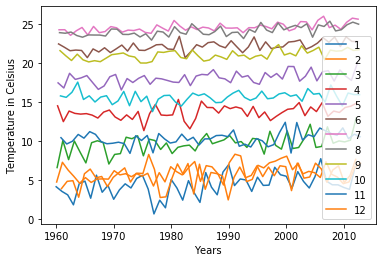

<Figure size 432x288 with 0 Axes>

In [10]:
from WorldController import WorldController
from DataModifier import DateMod, IPA
import pandas as pd
import glob
# worldController takes care of temperature/longitude
#datamodifer is used to modify other data

def convertDFIntoMonthDict(dataFrame):
    monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
    for name, group in dataFrame.groupby(by=[dataFrame.index.month]):
        monthDict[group.index[0].month] = group
    return monthDict

sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
sf6_obj = DateMod(sf6_data, 'average')
sf6_dict = convertDFIntoMonthDict(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <2012])

sf6_obj.monthDataFrame.to_csv('sf6_month_data')

n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
n2o_obj = DateMod(n2o_data, 'average')
n2o_obj.monthDataFrame.to_csv('N20_month_data')
n2o_dict = convertDFIntoMonthDict(n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <2012])

listOfCh4 = []
i = 0
for file in glob.glob('./data/Ch4/*'):
    ch4_data = pd.read_csv(file, header=0)
    listOfCh4.append(DateMod(ch4_data, 'value'))

    if i==10:
        break
    i+=1
joinedCH4 = pd.DataFrame()
# concat all dataframes we made, and create sum
for ch4DataFrame in listOfCh4:
    joinedCH4 = pd.concat([joinedCH4, ch4DataFrame.monthDataFrame], axis=1)


# aggregate each column to get sum of all of the files we scraped.
joinedCH4 = joinedCH4.agg('sum',axis=1)
joinedCH4 = joinedCH4.to_frame().reset_index().rename(columns={'index':'month',0:'sum'})
CH4_year = []
CH4_month = []
for date in joinedCH4.month:
    CH4_year.append(date.year)
    CH4_month.append(date.month)
joinedCH4.month = CH4_month
joinedCH4['year'] = CH4_year
CH4_obj = DateMod(joinedCH4, 'sum')

ch4_dict = convertDFIntoMonthDict(CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <2012])
#print(CH4_obj.dayDataFrame)
joinedCH4.to_csv('CH4_month_data')

# Don't know how to do these conversion.  Need help.
#ignoring the per capita data, we will use the yearly carbon emmision data and divide it into days then weeks and months
co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)
co2_data = co2_data.rename(columns={'Year':'year','Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)':'CarbonEmissions'})
co2_data = co2_data.loc[:,['year','CarbonEmissions']]
co2_data = co2_data.drop(co2_data.index[0]).reset_index(drop=True)
co2_data = co2_data.apply(pd.to_numeric)
co2_obj = DateMod(co2_data,'CarbonEmissions')
#print(joinedCH4)
co2_dict = convertDFIntoMonthDict(co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <2012])


greenhouse = [sf6_obj,n2o_obj,CH4_obj, co2_obj]
for obj in greenhouse:
    #print(IPA(obj.monthDataFrame[obj.monthDataFrame.keys().tolist()[0]]))
    pass
# initialize weather data into objs.



    #nitDf = pd.DataFrame()
    #allWeatherLongLat =  pd.concat(allWeatherLongLat, initDf)
    #print(allWeatherLongLat)
#self,sf6, n2o, co2, ch4

#mainControl.train_long_lat_model(None,None,None,None)




%increase for month 1  == 162.10702888102324
%increase for month 2  == 60.456368660308236
%increase for month 3  == 95.74984604281802
%increase for month 4  == 2.4541743829573344
%increase for month 5  == 13.997910454461774
%increase for month 6  == 1.4016863609385102
%increase for month 7  == 5.59492722416054
%increase for month 8  == 4.531561038568017
%increase for month 9  == 0.5381594228514223
%increase for month 10  == 0.9738950150704943
%increase for month 11  == 1.1735419234242528
%increase for month 12  == 82.65580255660811


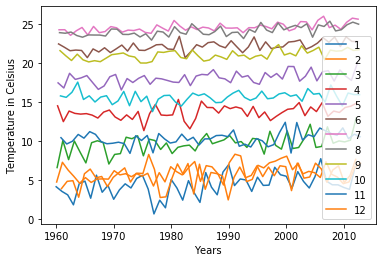

<Figure size 432x288 with 0 Axes>

In [14]:
mainControl = WorldController()

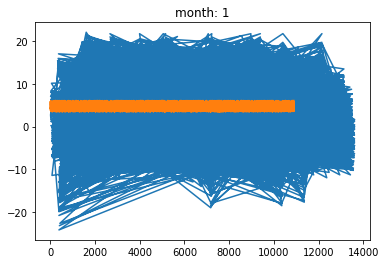

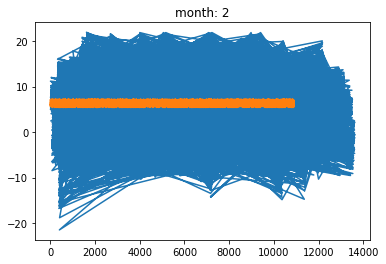

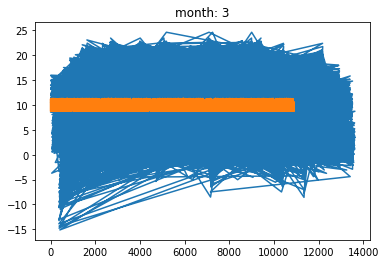

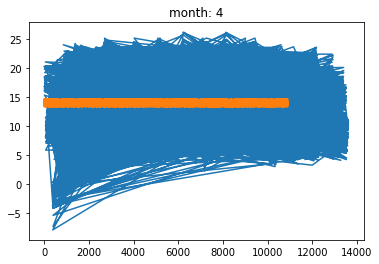

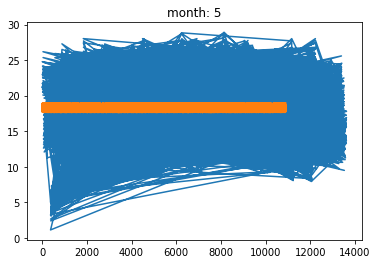

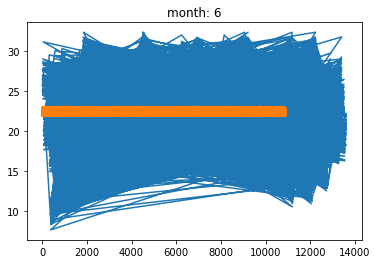

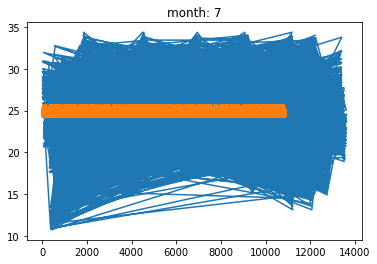

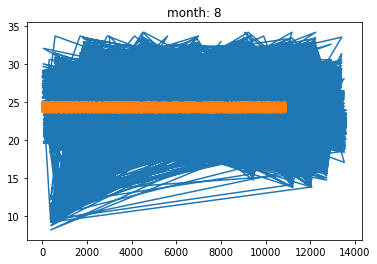

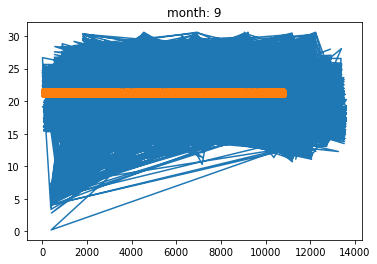

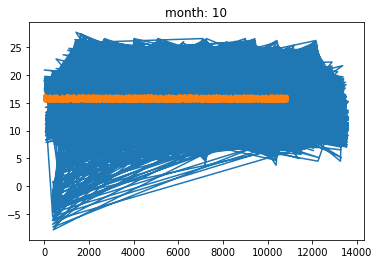

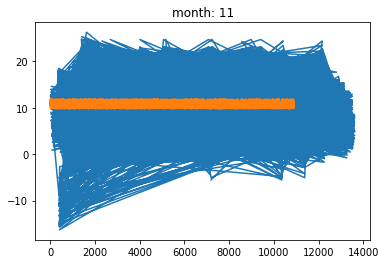

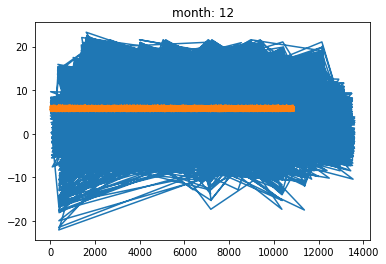

In [15]:
arrayOfDataToTrain = mainControl.getDfToTrain(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <=2012], n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <=2012], co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <=2012], CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <=2012])
    
#now we have an array with dataframes for each month, return several models.  One for each month.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
linearModel = []
i = 1
for df in arrayOfDataToTrain:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    linMod = LinearRegression().fit(X_train, y_train)
    linearModel.append(linMod)
    plt.title(f'month: {i}')
    plt.plot(y_test, label='real')
    plt.plot(linMod.predict(X_test), label='predicted')
    plt.show()
    i+=1



In [23]:
for i in range(len(arrayOfDataToTrain)):
    x =  arrayOfDataToTrain[i][arrayOfDataToTrain[i].columns[1:]]
    y = arrayOfDataToTrain[i][arrayOfDataToTrain[i].columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    print(pd.DataFrame([y_test.values,linearModel[i].predict(X_test)]))
    #print('Actual:{} Precited:{}'.format(y_test.values,linearModel[i].predict(X_test)))
    #print(y_test)
    #print(y_test)

      0         1          2          3         4        5        6      \
0  3.251000  3.266000  13.301000  10.129000  4.771000 -0.41200  7.58400   
1  4.290944  4.107241   5.353805   5.889968  4.998218  5.08568  5.08568   

      7         8         9      ...     10887     10888     10889     10890  \
0 -4.572000  4.138000  6.947000  ... -5.012000  14.14600 -8.830000  0.352000   
1  4.069814  4.390307  3.677839  ...  4.162175   5.08568  3.617469  4.627207   

      10891     10892     10893      10894     10895     10896  
0  8.238000  8.238000  9.808000  19.180000  7.428000  3.522000  
1  4.316484  4.316484  4.749019   4.191665  4.189849  6.099826  

[2 rows x 10897 columns]
     0         1          2          3         4         5          6      \
0  5.03100  4.377000  14.758000  10.359000  7.242000  3.435000  10.261000   
1  5.97242  5.646455   5.991985   7.200458  6.585003  6.299758   6.299758   

      7         8          9      ...     10887      10888     10889  \
0 -5.549